In [ ]:
import numpy as np
from tqdm.notebook import tqdm_notebook
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

images_resized = np.load('images_resized.npy', allow_pickle=True)
depths_resized = np.load('depths_resized.npy', allow_pickle=True)

x_use = np.load("x_use.npy", allow_pickle=True)
x_test = np.load("x_test.npy", allow_pickle=True)
y_use = np.load("y_use.npy", allow_pickle=True)
y_test = np.load("y_test.npy", allow_pickle=True)

# Convert to tensors
X_use_tensor = torch.FloatTensor(x_use)
y_use_tensor = torch.FloatTensor(y_use).unsqueeze(1)

In [2]:
print(len(x_use))
print(len(y_use))

1159
1159


In [3]:
# CNN Class (same as before, just output size changes)
class CNN(nn.Module):
    def __init__(self, input_channels, conv_channels, kernel_sizes, pool_sizes,
                 fc_hidden_sizes, input_height, input_width, dropout=0.2):
        super(CNN, self).__init__()

        conv_layers = []
        prev_channels = input_channels
        current_h, current_w = input_height, input_width

        for i, (out_channels, kernel_size, pool_size) in enumerate(zip(conv_channels, kernel_sizes, pool_sizes)):
            conv_layers.append(nn.Conv2d(prev_channels, out_channels, kernel_size))
            conv_layers.append(nn.BatchNorm2d(out_channels))
            conv_layers.append(nn.ReLU())

            current_h = current_h - kernel_size + 1
            current_w = current_w - kernel_size + 1

            if pool_size > 1:
                conv_layers.append(nn.MaxPool2d(pool_size))
                current_h = current_h // pool_size
                current_w = current_w // pool_size

            prev_channels = out_channels

        self.conv_network = nn.Sequential(*conv_layers)
        self.flatten = nn.Flatten()

        fc_layers = []
        flattened_size = prev_channels * current_h * current_w
        prev_size = flattened_size

        for hidden_size in fc_hidden_sizes:
            fc_layers.append(nn.Linear(prev_size, hidden_size))
            fc_layers.append(nn.BatchNorm1d(hidden_size))
            fc_layers.append(nn.ReLU())
            fc_layers.append(nn.Dropout(dropout))
            prev_size = hidden_size

        fc_layers.append(nn.Linear(prev_size, 1))
        self.fc_network = nn.Sequential(*fc_layers)

    def forward(self, x):
        x = self.conv_network(x)
        x = self.flatten(x)
        x = self.fc_network(x)
        return x

In [ ]:
results = []
input_channels = 3  # or 1 if grayscale
input_height = 30
input_width = 40

# Depth search: vary number of layers, increase channels progressively
depth_architectures = [
    # 2 layers
    {'conv_channels': [4, 8], 'kernel_sizes': [3, 3], 'pool_sizes': [2, 1], 'fc_hidden_sizes': []},
    {'conv_channels': [8, 16], 'kernel_sizes': [3, 3], 'pool_sizes': [2, 1], 'fc_hidden_sizes': []},

    # 3 layers
    {'conv_channels': [4, 4, 8], 'kernel_sizes': [3, 3, 3], 'pool_sizes': [2, 1, 1], 'fc_hidden_sizes': []},
    {'conv_channels': [8, 16, 32], 'kernel_sizes': [3, 3, 3], 'pool_sizes': [2, 1, 1], 'fc_hidden_sizes': []},

    # # 4 layers
    {'conv_channels': [4, 4, 8, 8], 'kernel_sizes': [3, 3, 3, 3], 'pool_sizes': [2, 1, 1, 1], 'fc_hidden_sizes': []},
    {'conv_channels': [8, 16, 32, 64], 'kernel_sizes': [3, 3, 3, 3], 'pool_sizes': [2, 1, 1, 1], 'fc_hidden_sizes': []}
]

# Width search: vary channels per layer, fix depth
width_architectures = [
    # 1 layer, varying width
    {'conv_channels': [4], 'kernel_sizes': [3, 3], 'pool_sizes': [2, 1], 'fc_hidden_sizes': []},
    {'conv_channels': [8], 'kernel_sizes': [3, 3], 'pool_sizes': [2, 1], 'fc_hidden_sizes': []},
    {'conv_channels': [16], 'kernel_sizes': [3, 3], 'pool_sizes': [2, 1], 'fc_hidden_sizes': []},
    {'conv_channels': [256], 'kernel_sizes': [3, 3], 'pool_sizes': [2, 1], 'fc_hidden_sizes': []},
    {'conv_channels': [1024], 'kernel_sizes': [3, 3], 'pool_sizes': [2, 1], 'fc_hidden_sizes': []}
]

weight_decays = [0]
dropout = 0.2 
lr = 0.001
batch_size = 64
iterations = 1
epochs = 20

In [5]:
# Search function for regression
def run_cnn_regression_search(architectures, weight_decays, lr, batch_size, iterations, epochs, dropout=0.2):
    """
    Run architecture search for CNN regression models.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    results = []

    for cnn_arch in tqdm_notebook(architectures, desc="Architecture"):
        for wd in tqdm_notebook(weight_decays, desc="Weight Decay", leave=False):

            iter_rmses = []
            iter_losses = []

            for iteration in tqdm_notebook(range(iterations), desc="Iteration", leave=False):
                X_train, X_val, y_train, y_val = train_test_split(
                    x_use, y_use, test_size=0.2, shuffle=True, random_state=iteration
                )

                X_train_tensor = torch.FloatTensor(X_train).view(-1, input_channels, input_height, input_width).to(device)
                y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1).to(device)
                X_val_tensor = torch.FloatTensor(X_val).view(-1, input_channels, input_height, input_width).to(device)

                train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
                train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

                model = CNN(
                    input_channels=input_channels,
                    conv_channels=cnn_arch['conv_channels'],
                    kernel_sizes=cnn_arch['kernel_sizes'],
                    pool_sizes=cnn_arch['pool_sizes'],
                    fc_hidden_sizes=cnn_arch['fc_hidden_sizes'],
                    input_height=input_height,
                    input_width=input_width,
                    dropout=dropout
                ).to(device)
                criterion = nn.MSELoss()
                optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

                train_losses = []

                for epoch in range(epochs):
                    model.train()
                    epoch_loss = 0
                    for batch_X, batch_y in train_loader:
                        optimizer.zero_grad()
                        outputs = model(batch_X)
                        loss = criterion(outputs, batch_y)
                        loss.backward()
                        optimizer.step()
                        epoch_loss += loss.item()

                    avg_loss = epoch_loss / len(train_loader)
                    train_losses.append(avg_loss)

                model.eval()
                with torch.no_grad():
                    y_val_pred = model(X_val_tensor).cpu().numpy().flatten()
                    y_val_pred = np.maximum(y_val_pred, 0)
                    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

                iter_rmses.append(val_rmse)
                iter_losses.append(train_losses)

            loss_array = np.array(iter_losses)
            mean_losses = np.mean(loss_array, axis=0)
            std_losses = np.std(loss_array, axis=0)

            results.append({
                'architecture': cnn_arch,
                'wd': wd,
                'val_rmse_mean': np.mean(iter_rmses),
                'val_rmse_std': np.std(iter_rmses),
                'val_rmses': iter_rmses,
                'train_losses': iter_losses,
                'train_loss_mean': mean_losses,
                'train_loss_std': std_losses
            })

    return results

In [6]:
# Plot results with standard deviation (similar to MLP style)
def plot_architecture_results(results, architectures, title):
    """
    Plot RMSE vs architecture with standard deviation as shaded region.
    """
    # Extract RMSE values for each architecture
    mean_rmse = []
    std_rmse = []
    arch_labels = []
    
    for arch in architectures:
        matching = [r for r in results if r['architecture'] == arch]
        if matching:
            mean_rmse.append(matching[0]['val_rmse_mean'])
            std_rmse.append(matching[0]['val_rmse_std'])
            arch_labels.append(str(arch['conv_channels']))
    
    mean_rmse = np.array(mean_rmse)
    std_rmse = np.array(std_rmse)
    x_indices = np.arange(len(arch_labels))
    
    # Create plot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot mean RMSE
    ax.plot(x_indices, mean_rmse, marker='o', color='blue', label='Mean RMSE', linewidth=2, markersize=8)
    
    # Add shaded region for standard deviation
    ax.fill_between(x_indices, mean_rmse - std_rmse, mean_rmse + std_rmse, 
                     alpha=0.3, color='blue', label='± 1 Std Dev')
    
    ax.set_xlabel("Architecture (Conv Channels)")
    ax.set_ylabel("RMSE (meters)")
    ax.set_xticks(x_indices)
    ax.set_xticklabels(arch_labels, rotation=45, ha='right')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best')
    
    plt.title(title)
    fig.tight_layout()
    plt.show()
    
    # Find best architecture
    best_idx = np.argmin(mean_rmse)
    best_arch = architectures[best_idx]
    
    print(f"Best: Architecture={best_arch['conv_channels']}, RMSE={mean_rmse[best_idx]:.3f} ± {std_rmse[best_idx]:.3f}")
    
    return best_idx

# Plot depth and width results side by side
def plot_depth_width_results(depth_results, depth_architectures, width_results, width_architectures):
    """
    Plot RMSE vs architecture for depth and width searches side by side.
    """
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    
    # Plot depth results
    ax = axes[0]
    mean_rmse = []
    std_rmse = []
    arch_labels = []
    
    for arch in depth_architectures:
        matching = [r for r in depth_results if r['architecture'] == arch]
        if matching:
            mean_rmse.append(matching[0]['val_rmse_mean'])
            std_rmse.append(matching[0]['val_rmse_std'])
            arch_labels.append(str(arch['conv_channels']))
    
    mean_rmse = np.array(mean_rmse)
    std_rmse = np.array(std_rmse)
    x_indices = np.arange(len(arch_labels))
    
    ax.plot(x_indices, mean_rmse, marker='o', label='Mean RMSE', linewidth=2, markersize=8)
    ax.fill_between(x_indices, mean_rmse - std_rmse, mean_rmse + std_rmse, 
                     alpha=0.3, label='± 1 Std Dev')
    ax.set_xlabel("Architecture (Conv Channels)")
    ax.set_ylabel("RMSE (meters)")
    ax.set_xticks(x_indices)
    ax.set_xticklabels(arch_labels, rotation=45, ha='right')
    ax.set_ylim([0.75, 1.35])
    ax.minorticks_on()
    ax.grid(True, which='major', alpha=0.5)
    ax.grid(True, which='minor', alpha=0.3, linestyle=':')
    ax.legend(loc='best')
    ax.set_title('Depth Search: Validation RMSE')
    
    best_depth_idx = np.argmin(mean_rmse)
    
    # Plot width results
    ax = axes[1]
    mean_rmse = []
    std_rmse = []
    arch_labels = []
    
    for arch in width_architectures:
        matching = [r for r in width_results if r['architecture'] == arch]
        if matching:
            mean_rmse.append(matching[0]['val_rmse_mean'])
            std_rmse.append(matching[0]['val_rmse_std'])
            arch_labels.append(str(arch['conv_channels']))
    
    mean_rmse = np.array(mean_rmse)
    std_rmse = np.array(std_rmse)
    x_indices = np.arange(len(arch_labels))
    
    ax.plot(x_indices, mean_rmse, marker='o', color='green', label='Mean RMSE', linewidth=2, markersize=8)
    ax.fill_between(x_indices, mean_rmse - std_rmse, mean_rmse + std_rmse, 
                     alpha=0.3, color='green', label='± 1 Std Dev')
    ax.set_xlabel("Architecture (Conv Channels)")
    ax.set_ylabel("RMSE (meters)")
    ax.set_xticks(x_indices)
    ax.set_xticklabels(arch_labels, rotation=45, ha='right')
    ax.set_ylim([0.75, 1.35])
    ax.minorticks_on()
    ax.grid(True, which='major', alpha=0.5)
    ax.grid(True, which='minor', alpha=0.3, linestyle=':')
    ax.legend(loc='best')
    ax.set_title('Width Search: Validation RMSE')
    
    best_width_idx = np.argmin(mean_rmse)
    
    plt.suptitle('CNN Architecture Search Results', y=0.99, fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Print best results
    best_depth = depth_results[best_depth_idx]
    best_width = width_results[best_width_idx]
    
    print(f"Best Depth: Architecture={best_depth['architecture']['conv_channels']}, RMSE={best_depth['val_rmse_mean']:.3f} ± {best_depth['val_rmse_std']:.3f}")
    print(f"Best Width: Architecture={best_width['architecture']['conv_channels']}, RMSE={best_width['val_rmse_mean']:.3f} ± {best_width['val_rmse_std']:.3f}")
    
    return best_depth_idx, best_width_idx

# Evaluate best models on test set
def evaluate_on_test(model_config, X_test, y_test):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Train final model on all training data
    X_train_tensor = torch.FloatTensor(x_use).view(-1, input_channels, input_height, input_width).to(device)
    y_train_tensor = torch.FloatTensor(y_use).unsqueeze(1).to(device)
    X_test_tensor = torch.FloatTensor(X_test).view(-1, input_channels, input_height, input_width).to(device)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    model = CNN(
        input_channels=input_channels,
        conv_channels=model_config['conv_channels'],
        kernel_sizes=model_config['kernel_sizes'],
        pool_sizes=model_config['pool_sizes'],
        fc_hidden_sizes=model_config['fc_hidden_sizes'],
        input_height=input_height,
        input_width=input_width,
        dropout=0.3
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0)
    
    # Track losses
    train_losses = []

    # Train
    for epoch in range(epochs):
        epoch_loss = 0
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
                
        # Calculate average loss for this epoch
        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
            
    # Test
    model.eval()
    with torch.no_grad():
        y_test_pred = model(X_test_tensor).cpu().numpy().flatten()
        y_test_pred = np.maximum(y_test_pred, 0)
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    return test_rmse, train_losses

In [ ]:
# Run depth search
print("Running depth search...")
depth_results = run_cnn_regression_search(
    architectures=depth_architectures,
    weight_decays=weight_decays,
    lr=lr,
    batch_size=batch_size,
    iterations=iterations,
    epochs=epochs,
    dropout=dropout
)

np.save('depth_results.npy', depth_results)

In [ ]:
# Run width search
print("\nRunning width search...")
width_results = run_cnn_regression_search(
    architectures=width_architectures,
    weight_decays=weight_decays,
    lr=lr,
    batch_size=batch_size,
    iterations=iterations,
    epochs=epochs,
    dropout=dropout
)
np.save('width_results.npy', width_results)

Architecture Search Results:


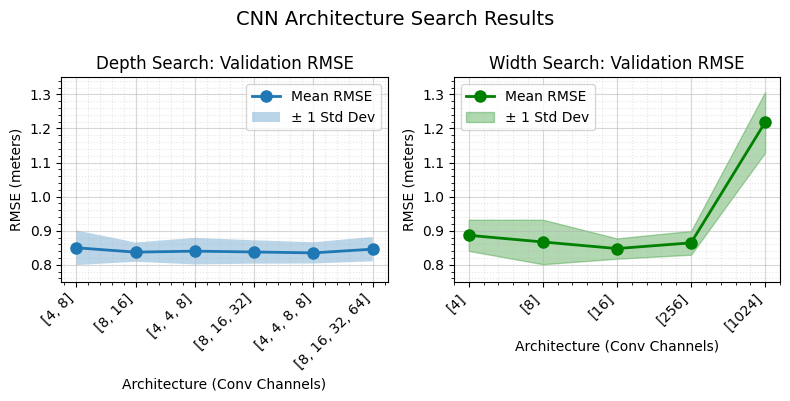

Best Depth: Architecture=[4, 4, 8, 8], RMSE=0.835 ± 0.031
Best Width: Architecture=[16], RMSE=0.848 ± 0.030
Depth
[{'conv_channels': [4, 8], 'kernel_sizes': [3, 3], 'pool_sizes': [2, 1], 'fc_hidden_sizes': []}, {'conv_channels': [8, 16], 'kernel_sizes': [3, 3], 'pool_sizes': [2, 1], 'fc_hidden_sizes': []}, {'conv_channels': [4, 4, 8], 'kernel_sizes': [3, 3, 3], 'pool_sizes': [2, 1, 1], 'fc_hidden_sizes': []}, {'conv_channels': [8, 16, 32], 'kernel_sizes': [3, 3, 3], 'pool_sizes': [2, 1, 1], 'fc_hidden_sizes': []}, {'conv_channels': [4, 4, 8, 8], 'kernel_sizes': [3, 3, 3, 3], 'pool_sizes': [2, 1, 1, 1], 'fc_hidden_sizes': []}, {'conv_channels': [8, 16, 32, 64], 'kernel_sizes': [3, 3, 3, 3], 'pool_sizes': [2, 1, 1, 1], 'fc_hidden_sizes': []}]
[0.85002329 0.83703773 0.84002137 0.83754612 0.83490655 0.84585831]
[0.05096738466825528, 0.028321697551524406, 0.039009797700795795, 0.03433995472871489, 0.031215341010814166, 0.03574441562456001]
Width
[{'conv_channels': [4], 'kernel_sizes': [3, 3

In [ ]:
depth_results = np.load("depth_results.npy", allow_pickle=True)
width_results = np.load("width_results.npy", allow_pickle=True)

# Plot both depth and width results side by side
print("Architecture Search Results:")
best_depth_idx, best_width_idx = plot_depth_width_results(
    depth_results, depth_architectures,
    width_results, width_architectures
)

mean_rmse = []
std_rmse = []

for arch in depth_architectures:
    matching = [r for r in depth_results if r['architecture'] == arch]
    if matching:
        mean_rmse.append(matching[0]['val_rmse_mean'])
        std_rmse.append(matching[0]['val_rmse_std'])
        
mean_rmse = np.array(mean_rmse)
print("Depth")
print(depth_architectures)
print(mean_rmse)
print(std_rmse)

mean_rmse = []
std_rmse = []

for arch in width_architectures:
    matching = [r for r in width_results if r['architecture'] == arch]
    if matching:
        mean_rmse.append(matching[0]['val_rmse_mean'])
        std_rmse.append(matching[0]['val_rmse_std'])
        
mean_rmse = np.array(mean_rmse)
print("Width")
print(width_architectures)
print(mean_rmse)
print(std_rmse)


# Get best architectures
best_depth = depth_results[best_depth_idx]
best_width = width_results[best_width_idx]

In [45]:
# Evaluate best depth architecture on test set
print("Evaluating best depth architecture on test set...")
depth_test_rmse, depth_train_losses = evaluate_on_test(best_depth['architecture'], x_test, y_test)

print(f"\nBest Depth Architecture: {best_depth['architecture']['conv_channels']}")
print(f"Validation RMSE: {best_depth['val_rmse_mean']:.3f} ± {best_depth['val_rmse_std']:.3f}")
print(f"Test RMSE: {depth_test_rmse:.4f}")

Evaluating best depth architecture on test set...

Best Depth Architecture: [4, 4, 8, 8]
Validation RMSE: 0.835 ± 0.031
Test RMSE: 0.8000


In [30]:
# Evaluate best width architecture on test set
print("Evaluating best width architecture on test set...")
width_test_rmse, width_train_losses = evaluate_on_test(best_width['architecture'], x_test, y_test)

print(f"\nBest Width Architecture: {best_width['architecture']['conv_channels']}")
print(f"Validation RMSE: {best_width['val_rmse_mean']:.3f} ± {best_width['val_rmse_std']:.3f}")
print(f"Test RMSE: {width_test_rmse:.3f}")

Evaluating best width architecture on test set...

Best Width Architecture: [16]
Validation RMSE: 0.848 ± 0.030
Test RMSE: 0.840


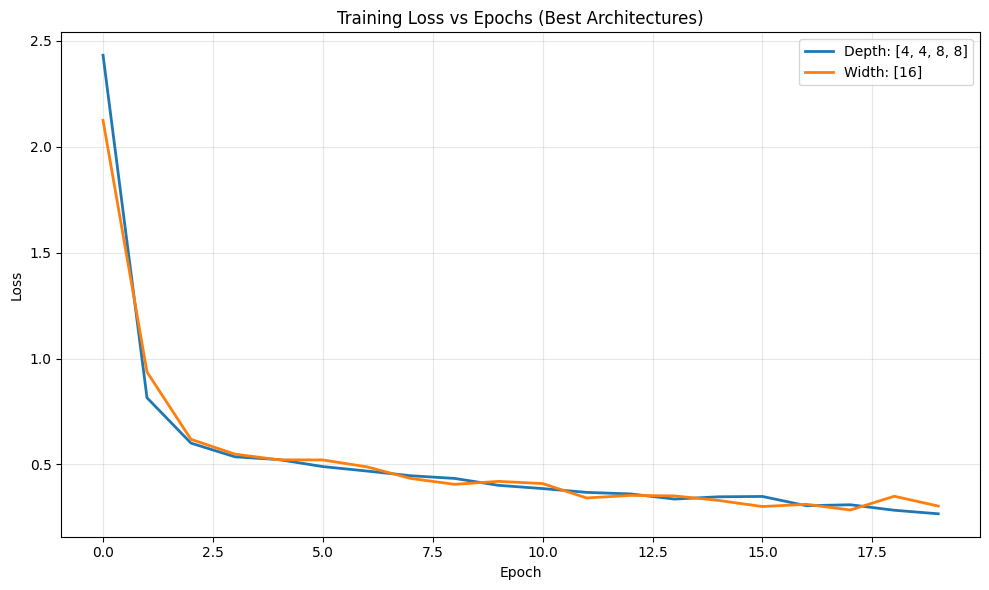

In [31]:
# Plot training losses for best models
plt.figure(figsize=(10, 6))
plt.plot(depth_train_losses, label=f'Depth: {best_depth["architecture"]["conv_channels"]}', linewidth=2)
plt.plot(width_train_losses, label=f'Width: {best_width["architecture"]["conv_channels"]}', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Epochs (Best Architectures)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

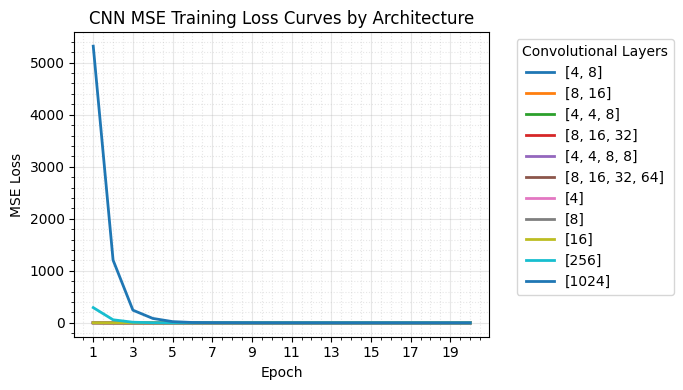

In [25]:
# Plot averaged training losses for all CNN architectures
import matplotlib.pyplot as plt

# Create single plot
plt.figure(figsize=(7, 4))

# Plot depth architectures (averaged)
for result in np.load('depth_results_one.npy', allow_pickle=True):
    # Average across iterations
    loss_array = np.array(result['train_losses'])
    mean_loss = np.mean(loss_array, axis=0)
    plt.plot(range(1, epochs+1), mean_loss, label=f"{str(result['architecture']['conv_channels'])}", linewidth=2)

# Plot width architectures (averaged)
for result in np.load('width_results_one.npy', allow_pickle=True):
    # Average across iterations
    loss_array = np.array(result['train_losses'])
    mean_loss = np.mean(loss_array, axis=0)
    plt.plot(range(1, epochs+1), mean_loss, label=f"{str(result['architecture']['conv_channels'])}", linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('CNN MSE Training Loss Curves by Architecture')
plt.minorticks_on()
plt.xticks(range(1, epochs+1, 2))
plt.grid(True, which='major', alpha=0.5)
plt.grid(True, which='minor', alpha=0.3, linestyle=':')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Convolutional Layers")
plt.tight_layout()
plt.show()